In [149]:
import custom_style; 
custom_style.style()

In [150]:
import pandas as pd
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
%matplotlib inline

from ipywidgets.widgets import interact
#from ipywidgets import widgets

from pprint import pprint
import pyfits

import datetime
import os
import glob
import shutil
import sys

sys.path.append('/Users/j35/git/BraggEdge/python')
from neutronbraggedge.experiment_handler import *
from neutronbraggedge.braggedge import BraggEdge

from plotly.offline import plot, init_notebook_mode, iplot
init_notebook_mode()
import plotly.plotly as py
import plotly.graph_objs as go

from IPython.html import widgets
from IPython.display import display

import gui_widgets
import normalization

%gui qt

#### vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv

## USER INPUT

#### Select a default starting directory (optional) 

In [ ]:
default_dir = "/Volumes/My Book Thunderbolt Duo/IPTS/BraggEdge/SNAP/April10_2015/"

#### What is the distance source-detector ?

In [ ]:
distance_source_detector = 16.09  #m

#### What is the detector offset ?

In [ ]:
detector_offset = 4500  #microS

#### List of elements you want the Bragg Edges?     

ex: ['Li','Al']

In [154]:
list_of_elements = ['Al', 'inconel']

#### How many Bragg Edges do you want to see?


In [162]:
number_of_bragg_edges = 5

#### ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

## Loading Data

In [156]:
%gui qt
dir_name = gui_widgets.gui_dname(dir = default_dir)
list_files = glob.glob(dir_name + '/*.fits')

# remove from list *_SummedImg.fits fille
list_files = [file for file in list_files if not "_SummedImg.fits" in file] 

# =================================
# Automatically load and convert Time Spectra
# =================================
spectra_files_name = glob.glob(dir_name + '/*_Spectra.txt')
spectra_file = spectra_files_name[0]

_tof_handler = TOF(filename = spectra_file)

_exp = Experiment(tof = _tof_handler.tof_array, 
                  distance_source_detector_m = distance_source_detector, 
                  detector_offset_micros = detector_offset)

lambda_array = _exp.lambda_array * 1e10 # to be in Angstroms

# =================================
# Retrieve powder Bragg edges
# =================================
_handler = BraggEdge(material=list_of_elements, 
                     number_of_bragg_edges = number_of_bragg_edges)
bragg_edges = _handler.bragg_edges
hkl = _handler.hkl

# =================================
# Load Data
# =================================
w = widgets.IntProgress(descrption='Loading data')
w.max = len(list_files)
display(w)

data = []
for _index, _file in enumerate(list_files):

    hdulist = pyfits.open(_file)
    hdu = hdulist[0]
    _image = np.asarray(hdu.data)
    data.append(_image)
    w.value = _index + 1

### Open Beam Selection and Data Normalization

In [157]:
options = ['Inside the same images', 'In another set of files']
ob_selection = widgets.RadioButtons( description = 'Where are your Open Beams?',
                                   options = options)
display(ob_selection)

[20, 241, 20, 495]

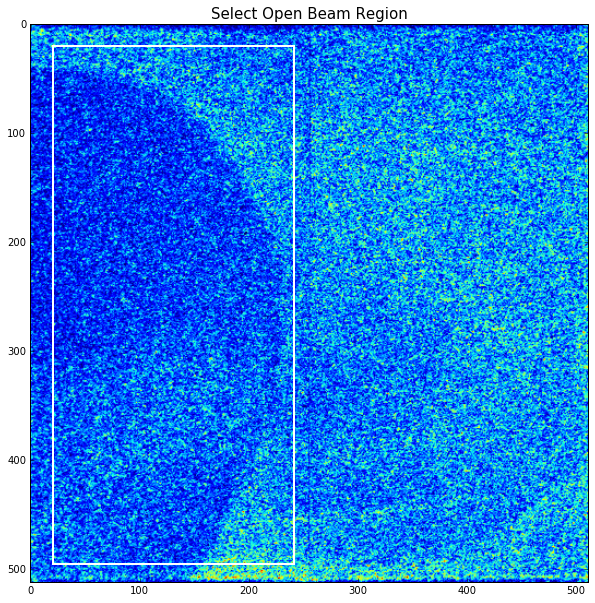

In [158]:
w = widgets.IntProgress(descrption='Loading Open Beams')

def plot_ob_image_for_cropping(file_index, x_left, x_right, y_top, y_bottom):
    
    fig = plt.figure(figsize=(10,10))
    ax_img = plt.subplot(111)
    ax_img.imshow(data[file_index])
    
#    _title = os.path.basename(list_files[file_index])
#    ax_img.set_title(_title)
    ax_img.set_title("Select Open Beam Region", fontsize=15)
 
    _rectangle = patches.Rectangle(
        (x_left, y_top),
        x_right - x_left,
        y_bottom - y_top,
        edgecolor = "white",
        linewidth = 2,
        fill = False)
    ax_img.add_patch(_rectangle)

    return [x_left, x_right, y_top, y_bottom]


if ob_selection.value == options[1]: # OB are in other files 
    
    # Let user select Open Beam files
    ob_file_names = gui_widgets.gui_fname(dir = default_dir)
    
    # load data
    ob_data = []
    for _index, _file in enumerate(ob_file_names):
        hdulist = pyfits.open(_file)
        hdu = hdulist[0]
        _image = np.asarray(hdu.data)
        ob_data.append(_image)
        
    # get averate OB
    mean_ob_data = normalization.calculate_average_ob_data(ob_data)
    
    # normalize all data by ob (I-I0/I0)
    normalized_data = normalization.normalized_data_by_ob_file(data, mean_ob_data)    
        
    
else: # same file

    # user select OB region
    [height, width] = data[0].shape

    number_of_files = len(data)
    crop = interact(plot_ob_image_for_cropping,
            file_index = widgets.IntSlider(min=0, 
                                          max=number_of_files-1,
                                          step=1, value=0, 
                                          description='Image index'),
            x_left = widgets.IntSlider(min=0, max=width-1, step=1, value=20),
            x_right = widgets.IntSlider(min=0, max=width-1, step=1, value=width/2),
            y_top = widgets.IntSlider(min=0, max=height-1, step=1, value=20), 
            y_bottom = widgets.IntSlider(min=0, max=height-1, step=1, value=height-20))


In [159]:
w = widgets.IntProgress(descrption='Loading Open Beams')

if ob_selection.value == options[0]: # same file
    
    [x_left, x_right, y_top, y_bottom] = crop.widget.result
    normalized_data = []
    w.max = len(data)
    display(w)
    for _index, _data in enumerate(data):
        
        _ob_region = _data[y_top:y_bottom, x_left:x_right]
        _mean_ob = np.mean(_ob_region)
        
        _normalized_data = (_data - _mean_ob) / (_mean_ob)
        normalized_data.append(_normalized_data)
        w.value = _index
    
else: # ob are in other files
    print("Nothing to do here!")


### Crop Region

[231, 492, 20, 492]

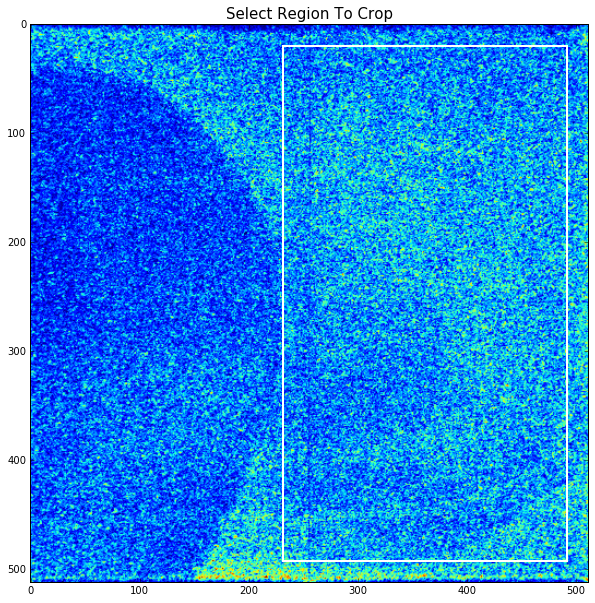

In [160]:
# =================================
# Crop Data
# =================================
data = normalized_data
[height, width] = data[0].shape

def plot_image_for_cropping(file_index, x_left, x_right, y_top, y_bottom):
    
    fig = plt.figure(figsize=(10,10))
    ax_img = plt.subplot(111)
    ax_img.imshow(data[file_index])
    
#    _title = os.path.basename(list_files[file_index])
#    ax_img.set_title(_title)
    ax_img.set_title("Select Region To Crop", fontsize=15)
 
    _rectangle = patches.Rectangle(
        (x_left, y_top),
        x_right - x_left,
        y_bottom - y_top,
        edgecolor = "white",
        linewidth = 2,
        fill = False)
    ax_img.add_patch(_rectangle)

    return [x_left, x_right, y_top, y_bottom]

number_of_files = len(list_files)
crop = interact(plot_image_for_cropping,
        file_index =widgets.IntSlider(min=0, 
                                      max=number_of_files-1,
                                      step=1, value=0, 
                                      description='Image index'),
        x_left = widgets.IntSlider(min=0, max=width-1, step=1, value=20),
        x_right = widgets.IntSlider(min=0, max=width-1, step=1, value=width-20),
        y_top = widgets.IntSlider(min=0, max=height-1, step=1, value=20), 
        y_bottom = widgets.IntSlider(min=0, max=height-1, step=1, value=height-20))

In [163]:
[x_left, x_right, y_top, y_bottom] = crop.widget.result

sum_cropped_data = []
for _data in normalized_data:
    _sum_data = np.sum(_data[y_top:y_bottom, x_left:x_right])
    sum_cropped_data.append(_sum_data)
    

# format hkl labels
_hkl_formated = {}
for _material in hkl:
    _hkl_string = []
    for _hkl in hkl[_material]:
        _hkl_s = ",".join(str(x) for x in _hkl)
        _hkl_s = _material + "\n" + _hkl_s
        _hkl_string.append(_hkl_s)
    _hkl_formated[_material] = _hkl_string
    
trace = go.Scatter(
    x = lambda_array,
    y = sum_cropped_data,
    mode = 'markers')

layout = go.Layout(
    width = "100%",
    height = 500,
    title = "Sum Counts vs TOF",
    xaxis = dict(
        title = "Lambda (Angstroms)"
                ),
    yaxis = dict(
        title = "Sum Counts"
                ),
    )

max_x = 6
y_off = 1

for y_index, _material in enumerate(bragg_edges):
    for _index, _value in enumerate(bragg_edges[_material]):
        if _value > max_x:
            continue
        bragg_line = {"type": "line",
                    'x0': _value,
                    'x1': _value,
                     'yref': "paper",
                     'y0': 0,
                     'y1': 1,
                     'line': {
                        'color': 'rgb(255, 0, 0)',
                        'width': 1
            }}
        layout.shapes.append(bragg_line)
        y_off = 1 - 0.25 * y_index
    
        # add labels to plots
        _annot = dict(
                    x=_value,
                    y= y_off,
                    text = _hkl_formated[_material][_index],
                    yref="paper",
                    font=dict(
                        family="Arial",
                        size=16,
                        color="rgb(150,50,50)"
                    ),
                    showarrow=True,
                    arrowhead=3,
                    ax=0,
                    ay=-25)
                
        layout.annotations.append(_annot)
        
data = [trace]
figure = go.Figure(data=data, layout=layout)
iplot(figure)

#### Powder Bragg Edges Recap 

In [164]:
print(_handler)

Material: Al
Lattice : 4.0460Å
Crystal Structure: FCC
Using local metadata Table: True
 h | k | l |	 d (Å)  |	 BraggEdge
---------------------------------------------
 1 | 1 | 1 |	 2.33596 |	 4.67192
 2 | 0 | 0 |	 2.02300 |	 4.04600
 2 | 2 | 0 |	 1.43048 |	 2.86095
 2 | 2 | 2 |	 1.16798 |	 2.33596
 3 | 1 | 1 |	 1.21991 |	 2.43983
 3 | 3 | 1 |	 0.92822 |	 1.85643
 3 | 3 | 3 |	 0.77865 |	 1.55731
 4 | 0 | 0 |	 1.01150 |	 2.02300
 4 | 2 | 0 |	 0.90471 |	 1.80943
 4 | 2 | 2 |	 0.82589 |	 1.65177
Material: inconel
Lattice : 3.5950Å
Crystal Structure: FCC
Using local metadata Table: True
 h | k | l |	 d (Å)  |	 BraggEdge
---------------------------------------------
 1 | 1 | 1 |	 2.07557 |	 4.15115
 2 | 0 | 0 |	 1.79750 |	 3.59500
 2 | 2 | 0 |	 1.27102 |	 2.54205
 2 | 2 | 2 |	 1.03779 |	 2.07557
 3 | 1 | 1 |	 1.08393 |	 2.16787
 3 | 3 | 1 |	 0.82475 |	 1.64950
 3 | 3 | 3 |	 0.69186 |	 1.38372
 4 | 0 | 0 |	 0.89875 |	 1.79750
 4 | 2 | 0 |	 0.80387 |	 1.60773
 4 | 2 | 2 |	 0.73383 |	 1.46765



## Export plot

### Give a label to this image

In [165]:
image_label = 'image 32'

In [166]:
nbr_cropped_data = len(sum_cropped_data)
_lambda_array = lambda_array[0: nbr_cropped_data]

_data = {'Lambda(Angstroms)': _lambda_array,
        'Normalized Counts': sum_cropped_data}

pandas_data = pd.DataFrame(_data, columns=['Lambda(Angstroms)', 'Normalized Counts'])

### Select Output Folder

In [167]:
%gui qt
output_folder = gui_widgets.gui_dname(dir = default_dir)

list_folders_in_path = dir_name.split('/')
data_folder = list_folders_in_path[-1]
output_file_name = os.path.join(output_folder, data_folder) + '_normalized.csv'

# Write metadata first
f = open(output_file_name, 'a')
f.write('# Label: %s\n' % image_label)
f.write('# distance_source_detector (m): %f\n' %distance_source_detector)
f.write('# detector_offset (micros): %f\n' %detector_offset)
f.write('# number of bragg edges: %d\n' %number_of_bragg_edges)
f.write('# List of elements: %s' % ",".join(list_of_elements))

pandas_data.to_csv(path_or_buf=output_file_name)
f.close()

In [168]:
list_folders_in_path = dir_name.split('/')
data_folder = list_folders_in_path[-1]
output_file_name = os.path.join(output_folder, data_folder) + '_normalized.csv'

# Write metadata first
f = open(output_file_name, 'a')
f.write('# Label: %s\n' % image_label)
f.write('# distance_source_detector (m): %f\n' %distance_source_detector)
f.write('# detector_offset (micros): %f\n' %detector_offset)
f.write('# number of bragg edges: %d\n' %number_of_bragg_edges)
f.write('# List of elements: %s' % ",".join(list_of_elements))

pandas_data.to_csv(path_or_buf=output_file_name)
f.close()